In [1]:
!pip install livelossplot;
!pip install torchsummary;
!pip install torchvision;
!pip install torchviz;
import math;
from inspect import isfunction;
from functools import partial;

%matplotlib inline
import matplotlib.pyplot as plt;
#from einops import rearrange

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torchvision;
import numpy as np;
from torchvision import transforms;
from livelossplot import PlotLosses;
from torchvision import transforms;
from torchvision.utils import make_grid;

import pandas as pd
from itertools import compress


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [36]:
import math
import random
from inspect import isfunction
from functools import partial

# %matplotlib inline
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import transforms


# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

class Encoder(nn.Module):

    def __init__(self, z_dim=256, hidden_size=1024, n_layers=3):
        super().__init__()
        self.z_dim = z_dim
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.resnet = ResNet(embed_dim=hidden_size, middle_size=hidden_size, num_layers=n_layers)
        self.dense1 = torch.nn.Linear(32 * 32 * 3, self.hidden_size)
        self.dense2 = torch.nn.Linear(self.hidden_size, self.z_dim)

    def forward(self, x, cond=None):
        img = 2 * x - 1.0
        # reshape img to combine last 3 dimensions
        
        img = img.reshape(img.shape[0], -1)
        # encode
        img = self.dense1(img)
        img = self.resnet(img, cond)
        weights = self.dense2(img)
        return weights


class Decoder(nn.Module):

    def __init__(self, hidden_size=1024, n_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.dense1 = torch.nn.Linear(256, self.hidden_size)
        self.resnet = ResNet(embed_dim=hidden_size, middle_size=hidden_size, num_layers=n_layers)
        self.dense2 = torch.nn.Linear(self.hidden_size, 32 * 32 * 3)

    def forward(self, x, cond=None):
        x = x.to(torch.float32)  # because linear layer expects float32
        x = self.dense1(x)
        x = self.resnet(x, cond)

        # return a distribution (make x all positive)
        logits = self.dense2(x)
        # reshape
        logits = logits.reshape(logits.shape[0], 3, 32, 32)
        return torch.distributions.independent.Independent(torch.distributions.Bernoulli(logits=logits), 3)


# Latent loss
def latent_loss(x_hat):
    var_1 = sigma2(gamma(1.0))
    mean_sqr = (1. - var_1) * torch.square(x_hat)
    loss_lat = 0.5 * torch.sum(mean_sqr + var_1 - torch.log(var_1) - 1, dim=1)
    return loss_lat


def recon_loss(img, enc_img, decoder: Decoder, cond=None):
    g_0 = gamma(0.)
    # numpy normal distribution
    eps_0 = torch.normal(0, 1, size=enc_img.shape)
    z_0 = variance_map(enc_img, g_0, eps_0)
    # rescale
    z_0_rescaled = z_0 / alpha(g_0)
    # decode
    decoded_img = decoder(z_0_rescaled, cond)
    # loss
    # convert img from numpy
    img_int = img.round()
    loss = -decoded_img.log_prob(img_int)
    return loss


############################################################################################################
# Diffusion process functions
############################################################################################################
# The timestep embedding is for the diffusion model to learn the temporal information of the time series
def get_timestep_embedding(timesteps, embedding_dim):
    t = timesteps
    t = t * 1000
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = t[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # pad
        emb = np.pad(emb, [(0, 0, 0), (0, 1, 0)], mode='constant')

    # combine last 2 dimensions
    emb = emb.reshape(emb.shape[0], -1)
    assert emb.shape == (t.shape[0], embedding_dim)

    return torch.from_numpy(emb).float()


# Forward diffusion process functions
def gamma(ts, gamma_min=-13.0, gamma_max=5.0):
    return gamma_max + (gamma_min - gamma_max) * ts


def sigma2(gamma_x):
    tensor = torch.tensor(gamma_x)
    return torch.sigmoid(-tensor)  # correct?


def alpha(gamma_x):
    return np.sqrt(1 - sigma2(gamma_x))


def variance_map(x, gamma_x, eps):
    return alpha(gamma_x) * x + np.sqrt(sigma2(gamma_x)) * eps


class ResNet(nn.Module):
    # Residual network
    def __init__(self, embed_dim, middle_size=1024, num_layers=10, activation=nn.GELU, norm=nn.LayerNorm):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.activation = activation
        self.norm = norm
        self.middle_size = middle_size

        self.blocks = nn.ModuleList()
        for _ in range(self.num_layers):
            self.blocks.append(self._make_block())

        self.cond_dense = nn.Linear(256, self.middle_size, bias=False)
        self.last_block = nn.ModuleList([self.norm([self.middle_size]), self.activation(),
                                         nn.Linear(self.middle_size, self.embed_dim)])

    def _make_block(self):
        # without convolutional layers
        layers = [self.norm([self.embed_dim]), self.activation(), nn.Linear(self.embed_dim, self.middle_size)]
        return nn.Sequential(*layers)

    def forward(self, x, cond):
        z = x
        for block in self.blocks:
            h = block(z)
            if cond is not None:
                h = h + self.cond_dense(cond)
            h = self.last_block[0](h)

        z = z + h
        return z


# Score neural network for the diffusion process. Approximates what you should do at each timestep
class ScoreNet(nn.Module):
    def __init__(self, latent_dim, embedding_dim, n_blocks=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.dense1 = nn.Linear(512, self.embedding_dim * 2)
        self.dense2 = nn.Linear(self.embedding_dim * 2, self.embedding_dim * 2)
        self.dense3 = nn.Linear(self.embedding_dim * 2, self.embedding_dim)
        self.dense4 = nn.Linear(self.latent_dim, self.embedding_dim)
        self.resnet = ResNet(embed_dim=embedding_dim, middle_size=embedding_dim, num_layers=n_blocks)

    def forward(self, x, t, conditioning):
        timestep = get_timestep_embedding(t, self.embedding_dim)
        # assert conditioning.shape[0]==timestep.shape[0] #as the output of encoder is (1, encoded_dim) this condition must eb satisfied
        cond = timestep
        cond = torch.cat((cond, conditioning), dim=1)
        cond = nn.SiLU()(self.dense1(cond))
        cond = nn.SiLU()(self.dense2(cond))
        cond = self.dense3(cond)

        h = self.dense4(x)  # hardcoded but should be latent_dim
        # h = torch.reshape(h, (1, 32, 1, 1))  # Reshaped for convolutional layers
        h = self.resnet(h, cond)
        return x + h


def diffusion_loss(z_0, t, score_net, conditioning, timesteps):
    # z_0 is the initial latent variable
    # t is the time step (time steps need to be discrete)
    # z_t is the latent variable at time t
    # z_t is a function of z_0 and t

    # Eps is a random tensor with the same shape as z_0 drawn from a normal distribution
    eps = torch.randn_like(z_0)
    gamma_x = gamma(t)
    z_t = variance_map(z_0, gamma_x, eps)

    # The score function is the derivative of the latent variable with respect to time
    score = score_net(z_t, t, conditioning)
    loss_diff_mse = torch.sum((torch.square(eps - score)), dim=-1)

    # The diffusion process is a stochastic process
    T = timesteps
    s = t - (1. / T)
    g_s = gamma(s)
    loss_diff = .5 * T * np.expm1(g_s - gamma_x) * loss_diff_mse

    return loss_diff


class VariationalDiffusion(nn.Module):
    timesteps: int = 1000
    layers: int = 32
    gamma_min: float = -5
    gamma_max: float = 1
    antithetic: bool = True
    classes: int = 10 + 26 + 26 + 1  # 10 digits + 26 lowercase + 26 uppercase

    def __init__(self, latent_dim, embedding_dim, n_blocks=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.score_net = ScoreNet(self.latent_dim, self.embedding_dim, n_blocks=n_blocks)
        self.encoder = Encoder(z_dim=embedding_dim)
        self.decoder = Decoder()
        self.embedding_vectors = nn.Embedding(self.classes, self.embedding_dim)

    def forward(self, img, conditioning=None):  # combined loss for diffusion and reconstruction
        cond = self.embedding_vectors(conditioning)

        # encoding image
        z_0 = self.encoder(img, cond)
        # encoder loss
        loss_recon = recon_loss(img, z_0, self.decoder, cond=cond)

        loss_latent = latent_loss(z_0)

        # diffusion loss
        # we need to sample time steps
        if self.antithetic:
            orig_t = torch.rand(1)
            t = np.mod(orig_t + np.arange(0., 1., step=1. / img.shape[0]), 1.0)
            # turn to float32
            t = t.to(torch.float32)
            t = torch.reshape(t, (img.shape[0], 1))
        else:
            t = torch.rand((img.shape[0], 1))

        # discretize time steps
        t = np.ceil(t * self.timesteps) / self.timesteps
        loss_diff = diffusion_loss(z_0, t, self.score_net, cond, self.timesteps)
        scale= torch.div(1,(torch.prod(torch.tensor(img.shape[1:]))*np.log(2)))
        out=torch.mul(torch.mean(loss_recon)+ torch.mean(loss_latent) + torch.mean(loss_diff), scale)
        return out,  (torch.mean(loss_recon)*scale, torch.mean(loss_latent)*scale, torch.mean(loss_diff)*scale)

    def sample(self, z_t, step, timesteps, conditioning, guidance_weight=0.):
        eps = torch.randn_like(z_t)
        t = (timesteps - step) / timesteps
        s = (timesteps - step - 1) / timesteps
        #print("Sampling:",t)
        g_s = gamma(s)
        g_t = gamma(t)

        cond = conditioning

        eps_hat_cond = self.score_net(z_t, g_t * torch.ones(z_t.shape[0]), cond)

        eps_hat_uncond = self.score_net(z_t, g_t * torch.ones(z_t.shape[0]), torch.zeros_like(z_t))

        eps_hat = (1. + guidance_weight) * eps_hat_cond - guidance_weight * eps_hat_uncond
        a = torch.sigmoid(torch.tensor(g_s))
        b = torch.sigmoid(torch.tensor(g_t))
        c = -np.expm1(g_t - g_s)
        sigma_t = torch.sqrt(sigma2(g_t))
        z_s = torch.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + np.sqrt((1. - a) * c) * eps
        return z_s

    def sample_from_prior(self, t, num_samples=1):
        return self.sample(t, conditioning=torch.zeros((num_samples, 0)), num_samples=num_samples)

    def sample_from_posterior(self, t, conditioning, num_samples=1):
        return self.sample(t, conditioning=conditioning, num_samples=num_samples)

    def recon(self, img, timesteps, t, conditioning, num_samples=1):
        cond = self.embedding_vectors(conditioning)

        z_0 = self.encoder(img, cond)
        T = timesteps
        t_n = np.ceil(t * T)
        t = t_n / T
        g_t = gamma(t)
        eps = torch.randn(img.shape[0], self.latent_dim)
        z_t = variance_map(z_0, g_t, eps)
        diffused = z_t
        img_steps=[]
        g0 = gamma(0.0)
        var0 = sigma2(g0)
        #eps2 = torch.randn_like(z_t)
        for t in range((T - t_n).astype('int'),timesteps):
            #print(t)
            diffused = self.sample(diffused, t, T, cond)
            if t % 1 == 0:
                img_steps_rescaled=diffused/ np.sqrt(1.0 - var0)
                imgs_steps_recon = self.decoder(img_steps_rescaled, cond)
                img_steps.append(imgs_steps_recon.mean)
        z0_rescaled = diffused / np.sqrt(1.0 - var0)
        reconstructed = self.decoder(z0_rescaled, cond)
        
        return reconstructed.mean, img_steps


def TrainVDM(batch_size_train, n_epochs):
    
    
    classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        
    dataset_full=torchvision.datasets.CIFAR10('./', train=True, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor()
                                    ]))
    idx = list(np.array(dataset_full.targets)==7) #| (dataset_full.targets==2) | (dataset_full.targets==5) | (dataset_full.targets==6)
    dataset_full.targets = list(compress(dataset_full.targets, idx))
    dataset_full.data = list(compress(dataset_full.data , idx))

    train_loader = torch.utils.data.DataLoader(
    dataset_full, batch_size=256, shuffle=False, num_workers=8)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./', train=False, download=False,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor()
                                   ])), batch_size=batch_size_train, shuffle=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #conditioning = torch.zeros(img.shape[0], dtype=torch.int32)
    
    model= VariationalDiffusion(256,256, 4).to(device)
    # model.load_state_dict(torch.load( "./MODEL_corrected_512_50_32_0.001")["state_dict"])
    
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, eps=1e-8, weight_decay=1e-4)
    
    
    # optimizer.load_state_dict(torch.load ("./MODEL_corrected_512_50_32_0.0008")["optimizer"])
    # train_losses=torch.load ("./MODEL_corrected_512_50_32_0.0008")["losslogger"]
    
    model.train()
    log_interval = 50
    train_losses = []
    train_counter = []
    for epoch in range(1, n_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            conditioning =target
            loss, values = model(data, conditioning)
            loss.backward()
            optimizer.step()
            # plt.plot(train_losses)
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f},{}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item(), values))
                train_losses.append(loss.item())
                train_counter.append(
                    (batch_idx * 1000) + ((epoch - 1) * len(train_loader.dataset)))
    plt.plot(train_losses, train_counter)
    plt.show()     
    state = {'epoch': epoch+1, 'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(), 'losslogger': train_losses }
    torch.save(state, "./Cifar_100ep_0.001_256_4_large_middle")
    return model

        
if __name__ == "__main__":
    # model
    model = VariationalDiffusion(256,256, 5)
    # a random image 28x28x1 in range [0,1]
    img = torch.rand((256, 3, 32, 32))
    conditioning = torch.zeros(img.shape[0], dtype=torch.int32)
    losses = model(img, conditioning)
    # rescale losses
    #for i in losses:
    #    print((i * (1. / (np.prod(img.shape[1:]) * np.log(2)))).mean())
    output,samples=model.recon(img, 1000, 0.0, conditioning, 1)
 
    print("OK")



OK


C:\Users\20210826\AppData\Local\Temp\ipykernel_22544\2999243794.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(gamma_x)


Files already downloaded and verified


C:\Users\20210826\AppData\Local\Temp\ipykernel_22544\2999243794.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(gamma_x)


Train Epoch: 1 [0/5000 (0%)]	Loss: 2.662917,(tensor(1.0623, grad_fn=<MulBackward0>), tensor(4.4015e-08, grad_fn=<MulBackward0>), tensor(1.6006, grad_fn=<MulBackward0>))
Train Epoch: 2 [0/5000 (0%)]	Loss: 1.668086,(tensor(0.7411, grad_fn=<MulBackward0>), tensor(2.1468e-07, grad_fn=<MulBackward0>), tensor(0.9270, grad_fn=<MulBackward0>))
Train Epoch: 3 [0/5000 (0%)]	Loss: 1.375652,(tensor(0.6366, grad_fn=<MulBackward0>), tensor(1.8312e-07, grad_fn=<MulBackward0>), tensor(0.7391, grad_fn=<MulBackward0>))
Train Epoch: 4 [0/5000 (0%)]	Loss: 1.166987,(tensor(0.5955, grad_fn=<MulBackward0>), tensor(1.2837e-07, grad_fn=<MulBackward0>), tensor(0.5715, grad_fn=<MulBackward0>))
Train Epoch: 5 [0/5000 (0%)]	Loss: 1.023815,(tensor(0.5575, grad_fn=<MulBackward0>), tensor(1.0397e-07, grad_fn=<MulBackward0>), tensor(0.4663, grad_fn=<MulBackward0>))
Train Epoch: 6 [0/5000 (0%)]	Loss: 0.933447,(tensor(0.5277, grad_fn=<MulBackward0>), tensor(8.6803e-08, grad_fn=<MulBackward0>), tensor(0.4058, grad_fn=<Mu

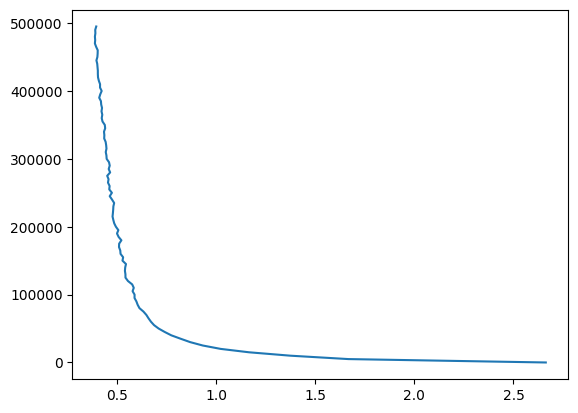

In [37]:
model=TrainVDM(256,100)


In [27]:
VDM= VariationalDiffusion(256, 256, 6)
VDM.load_state_dict(torch.load( "./Cifar_400ep_0.001_256_6")["state_dict"])
train_losses=torch.load ("./Cifar_400ep_0.001_256_6")["losslogger"]

Text(0, 0.5, 'Overall loss')

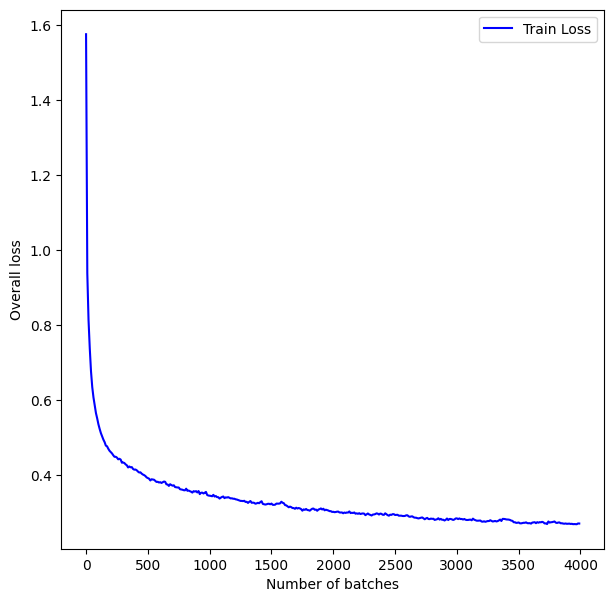

In [28]:
fig = plt.figure(figsize=(7,7))
index=list(range(0,len(train_losses)*10,10))
plt.plot(index,train_losses,color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('Number of batches')
plt.ylabel('Overall loss')

torch.Size([6, 3, 32, 32])
tensor(1.)
tensor(0.4288)
torch.Size([3, 192, 32]) torch.Size([3, 192, 32])


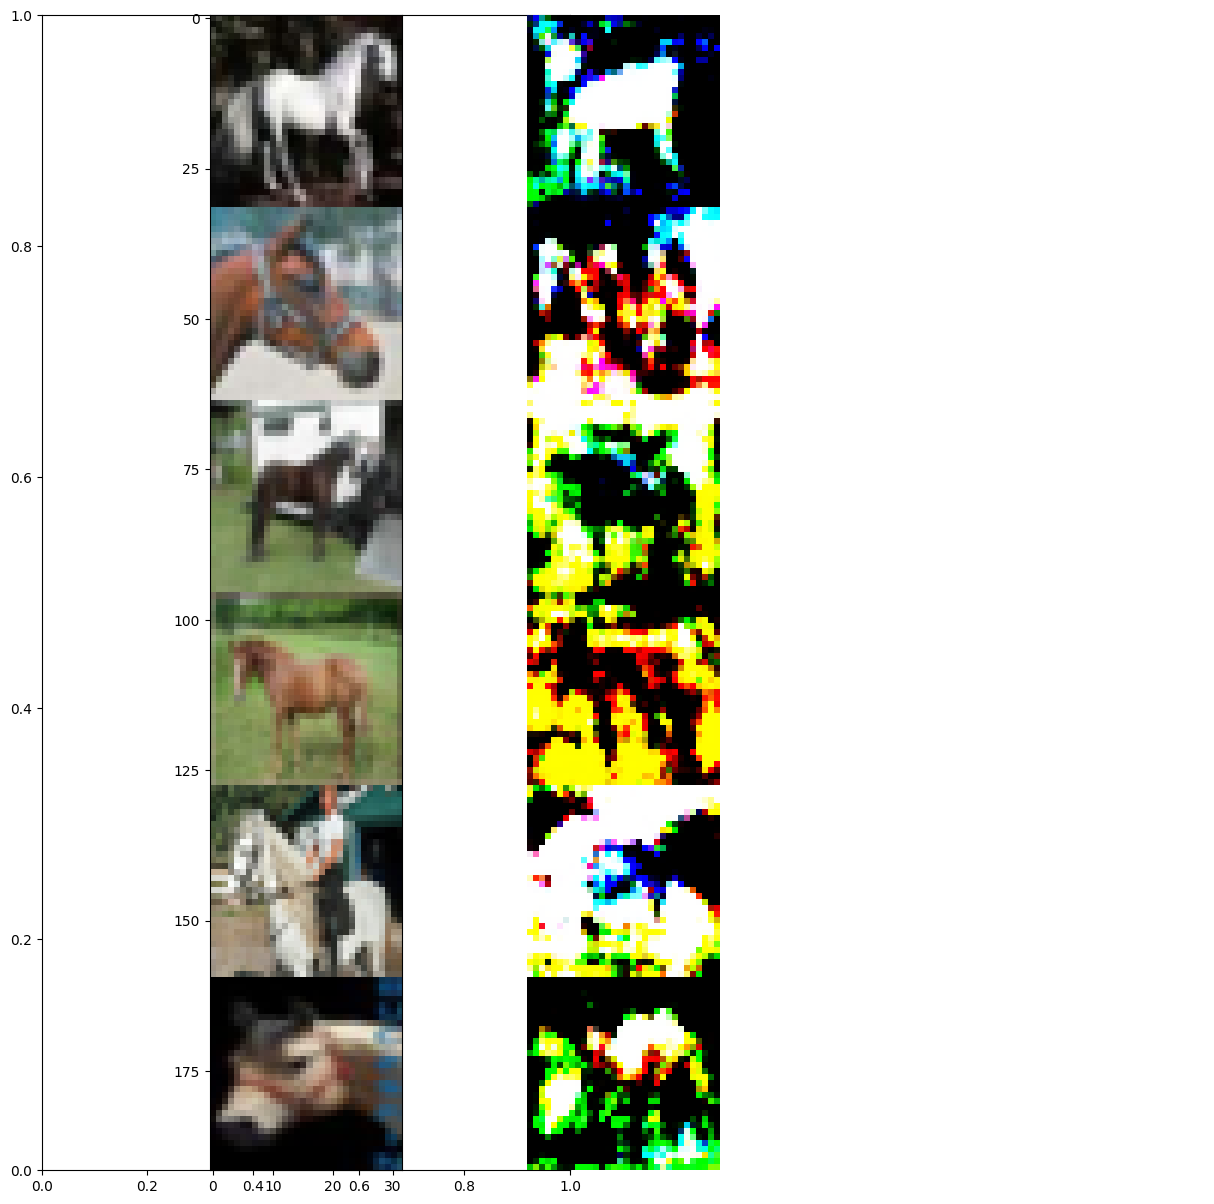

In [34]:
dataset_full=torchvision.datasets.CIFAR10('./', train=False, download=False,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor()
                                ]))
idx = list(np.array(dataset_full.targets)==7) #| (dataset_full.targets==2) | (dataset_full.targets==5) | (dataset_full.targets==6)
dataset_full.targets = list(compress(dataset_full.targets, idx))
dataset_full.data = list(compress(dataset_full.data , idx))

train_loader = torch.utils.data.DataLoader(
dataset_full, batch_size=6, shuffle=False)
batch = next(iter(train_loader))
#(0.1307,), (0.3081,)
#tf.random.uniform(image.shape) < image / 255.0
def test(train_loader, VDM):
    #batch=torch.empty((10,1,28,28), dtype=torch.int64)
    VDM.eval()
    with torch.no_grad():
        data, target = next(iter(train_loader))
        print(data.shape)
        conditioning =target
        output,samples=VDM.recon(data, 1000, 0.9, conditioning, 1)
        #print(output.shape)
        #print(data[1].min()
        print(output.max())
        loss=torch.nn.MSELoss()
        print(torch.sqrt(loss(output, data)))
    fig, ax = plt.subplots(1,2,figsize=(15,15))
    plt.axis('off')

    global img, img_in
    #fig.set_cmap('hot')
    
    img=torchvision.utils.make_grid(output, 1, 0)
    img_in=torchvision.utils.make_grid(data, 1, 0)
    fig.add_subplot(1, 1, 1)
    print(img_in.shape, img.shape)
    plt.imshow( np.transpose(img.numpy(), (1, 2, 0)),cmap="hot")
    plt.axis('off')
    fig.add_subplot(1, 2, 1)
    plt.imshow( np.transpose(img_in.numpy(), (1, 2, 0)),cmap="hot" ) 
    
    plt.show()
test(train_loader,VDM)
#loss_recon, loss_latent, loss_diff
#loss_recon should be highest

# Animation

tensor([9])
10
Sampling: 0.9
11
Sampling: 0.89
12
Sampling: 0.88
13
Sampling: 0.87
14
Sampling: 0.86
15
Sampling: 0.85
16
Sampling: 0.84
17
Sampling: 0.83
18
Sampling: 0.82
19
Sampling: 0.81
20
Sampling: 0.8
21
Sampling: 0.79
22
Sampling: 0.78
23
Sampling: 0.77
24
Sampling: 0.76
25
Sampling: 0.75
26
Sampling: 0.74
27
Sampling: 0.73
28
Sampling: 0.72
29
Sampling: 0.71
30
Sampling: 0.7
31
Sampling: 0.69
32
Sampling: 0.68
33
Sampling: 0.67
34
Sampling: 0.66
35
Sampling: 0.65
36
Sampling: 0.64
37
Sampling: 0.63
38
Sampling: 0.62
39
Sampling: 0.61
40
Sampling: 0.6
41
Sampling: 0.59
42
Sampling: 0.58
43
Sampling: 0.57
44
Sampling: 0.56
45
Sampling: 0.55
46
Sampling: 0.54
47
Sampling: 0.53
48
Sampling: 0.52
49
Sampling: 0.51
50
Sampling: 0.5
51
Sampling: 0.49
52
Sampling: 0.48
53
Sampling: 0.47
54
Sampling: 0.46
55
Sampling: 0.45
56
Sampling: 0.44
57
Sampling: 0.43
58
Sampling: 0.42
59
Sampling: 0.41
60
Sampling: 0.4
61
Sampling: 0.39
62
Sampling: 0.38
63
Sampling: 0.37
64
Sampling: 0.36
65
S

MovieWriter ffmpeg unavailable; using Pillow instead.


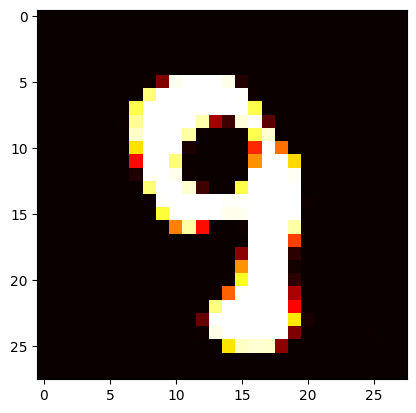

In [233]:
import matplotlib.animation as animation
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('./', train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=1, shuffle=True)
#(0.1307,), (0.3081,)
#tf.random.uniform(image.shape) < image / 255.0
samples=[]
    #batch=torch.empty((10,1,28,28), dtype=torch.int64)
VDM.eval()
with torch.no_grad():
    data, target = next(iter(test_loader))
    print(target)
    conditioning =target
    output,samples=VDM.recon(data, 1000, 0.9, conditioning, 1)
#print(len(samples))
timesteps=1000
fig = plt.figure()
ims = []
for i in range(len(samples)):
    im = plt.imshow(samples[i].reshape(28, 28, 1).detach().numpy(), cmap="hot", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=10, blit=True,repeat=True, repeat_delay=1000)
animate.save('diffusion.gif')
#plt.show()

In [239]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=1, shuffle=True)
data, target = next(iter(test_loader))
img=data
output=VDM.recon(img=img,t=0.9)
plt.imshow( np.transpose(output[0].detach().numpy(), (1, 2, 0)))
output[0].detach().numpy().shape
plt.imshow( np.transpose(img[0].detach().numpy(), (1, 2, 0)))
(torch.prod(torch.tensor(img.shape[1:]))*np.log(2))

RuntimeError: Dataset not found. You can use download=True to download it

In [ ]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=10, shuffle=True)
data, target = next(iter(test_loader))
data.min()

tensor(0.)